In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from numba import njit
from scipy.special import genlaguerre

plt.style.use('Ltx.mplstyle')

Bad value in file 'Ltx.mplstyle', line 25 ("axes.prop_cycle: cycler(['#1d65c9', '#ff1a1a', '#ff6a00', '#ffd500', '#bfe500', '#7ee236'])"): Key axes.prop_cycle: "cycler(['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


In [2]:
results_path = "../Code/Results/"
figures_path = "figures/"

In [3]:
"""COLOURS"""
AmC_DEEP_BLUE = '#1d65c9'
AmC_BRIGHT_RED = '#ff1a1a'
AmC_VIVID_ORANGE = '#ff6a00'
AmC_BOLD_YELLOW = '#ffd500'
AmC_LIGHT_GREEN = '#bfe500'
AmC_LIME_GREEN = '#7ee236'


In [4]:
@njit('f8(f8, f8)')
def V(alpha: float, r: float) -> float:

    """Calculates the 1D Morse-Coulomb potencial given the position r"""
    

    D = 1/alpha ; beta = 1/(alpha*np.sqrt(2))

    if r > 0:
        pot = -1/np.sqrt(r*r + alpha*alpha)
    else:
        pot = D*( np.exp( -2*beta*r) -2*np.exp( -beta*r ) )
    return pot

@njit('f8(f8)')
def Vc(r: float) -> float:

    if r > 0:
        pot = -1/r
    else:
        pot = np.inf
    return pot

@njit('f8[:](f8, f8)')
def return_points(alpha: float, E: float) -> np.ndarray:

    """Calculates the return points of a particle based on alpha and the total Energy"""
    
    rm = -alpha*np.sqrt(2)*np.log( np.sqrt( alpha*E + 1 ) + 1 )
    rM = np.sqrt( 1/(E**2) - alpha**2 )
    
    return np.array([rm, rM])

@njit('f8(f8, f8, f8)')
def MC_bound_linear_momentum(alpha: float, E: float, r: float) -> float:

    """Calculates the Momentum of a bound particle given its position and total Energy"""
    

    return ( np.sqrt(2*(E - V(alpha, r))) )

@njit('f8(f8, f8, f8)')
def MC_classic_action( alpha: float, Ei: float, dr: float = 1.e-6 ) -> float:
    
    """Calculates the action of a bound particle in the Morse-Coulomb potential"""


    #function's parameters

    rm, rM = return_points( alpha, Ei )

    n = int( (rM - rm)/dr )


    sum1 = sum2 = 0

    for i in range(1, n):
        r = rm + i * dr
        if i % 2 == 0:
            sum2 += MC_bound_linear_momentum( alpha, Ei, r )
        else:
            sum1 += MC_bound_linear_momentum( alpha, Ei, r )
    integral = (dr / 3) * ( 2 * sum2 + 4 * sum1 )

    return integral/np.pi


@njit('f8(f8, f8, f8)')
def MC_angular_frequency( alpha: float, Ei: float, dE: float = 1.e-4 ) -> float:
    
    """Calculates the agular frequency of a particle in the Morse-Coulomb potential derivating action"""


    return ( (1/(12*dE))*( MC_classic_action(alpha, Ei-2*dE, dE ) 
                          - 8*MC_classic_action(alpha, Ei-dE, dE ) 
                          + 8*MC_classic_action(alpha, Ei+dE, dE ) 
                          - MC_classic_action(alpha, Ei+2*dE, dE ) 
                          ) 
            )**(-1)

@njit( 'f8(f8)' )
def C_classic_action(E: float) -> float:

    """Calculates the classic action of a particlein Coulomb potential"""

    J = 1/np.sqrt( -2*E )
    return J

def C_angular_frequency(E: float) -> float:
    
    """Calculates the angular frequency of a particle in Coulomb potential"""

    omg = 1/C_classic_action(E)**3
    return omg

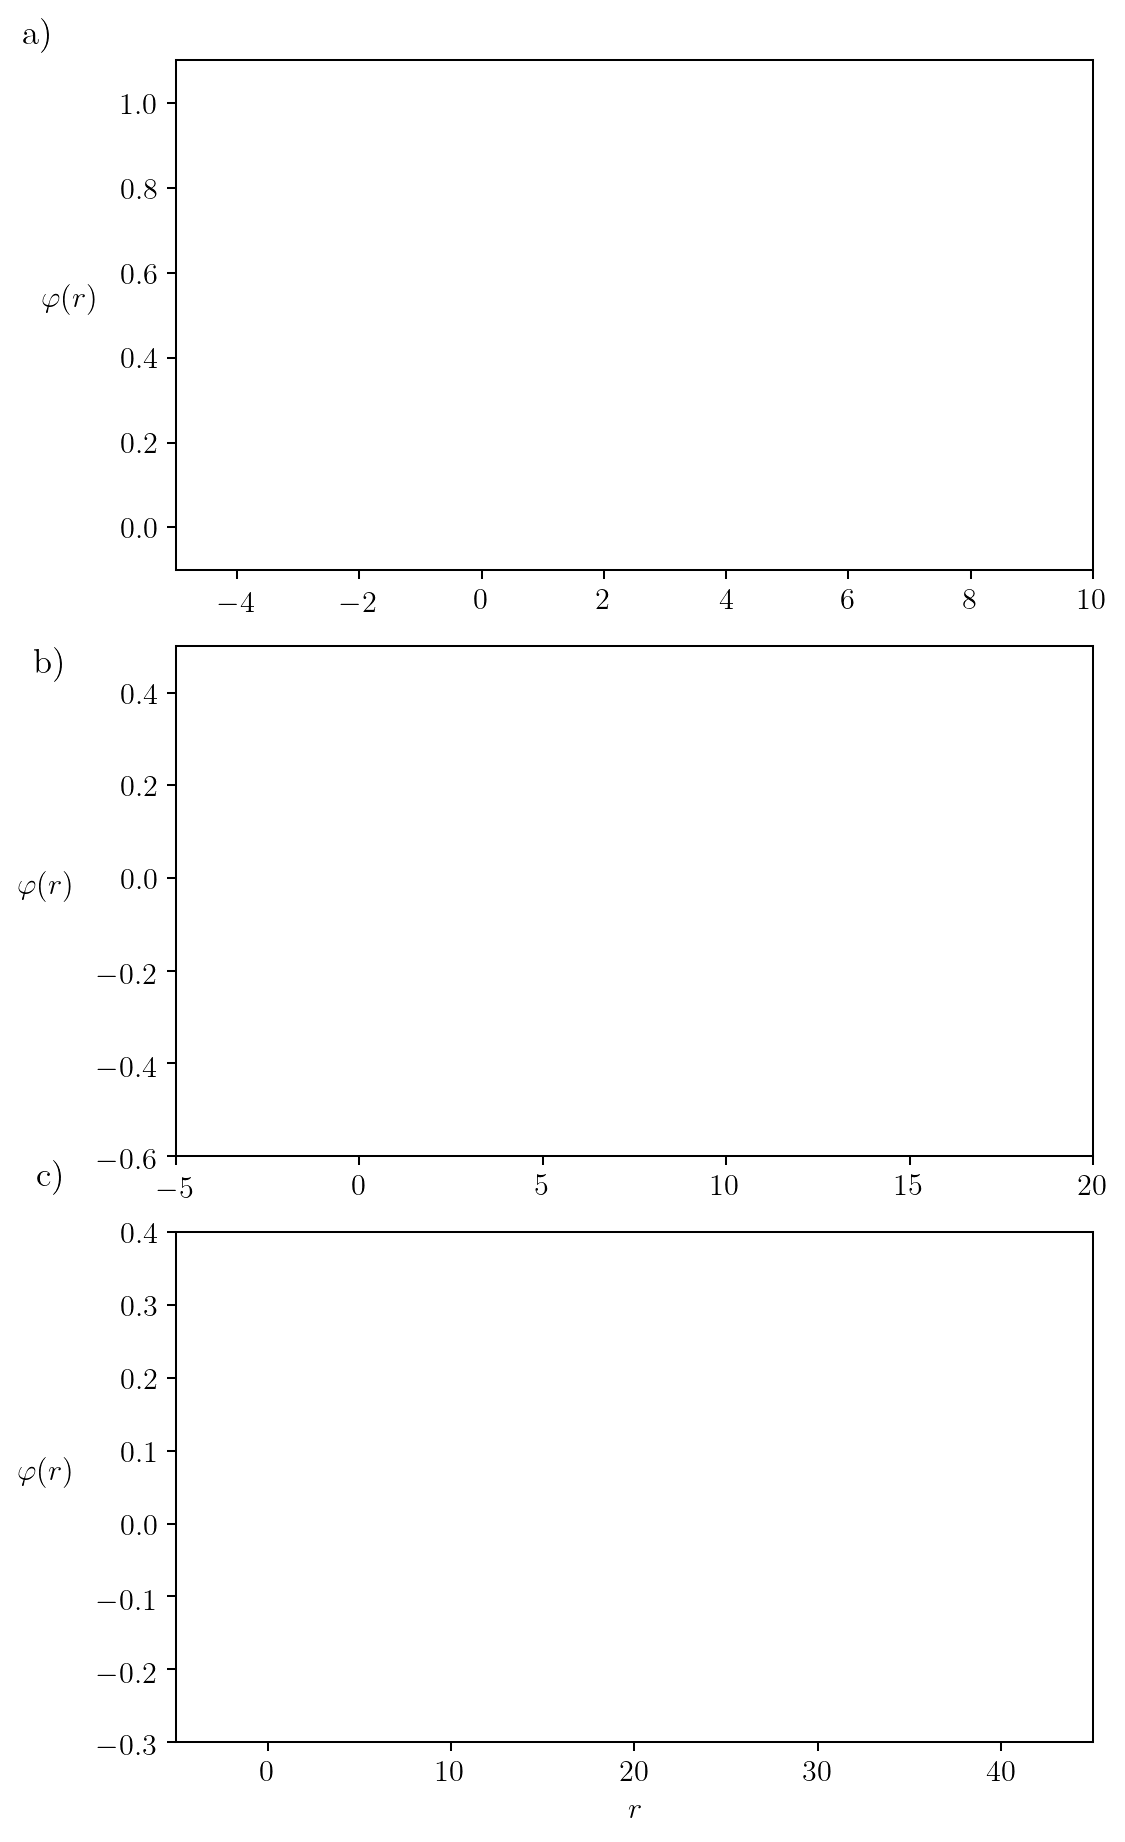

In [5]:
fig4, axs4 = plt.subplots(3, 1)
fig4.set_figwidth(6.5)
fig4.set_figheight(12)
fig4.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.15)

#fig4.gca().set_xlim(-(np.pi*1.01), (np.pi*1.01))
#fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig4.gca().set_xlabel(r"$r$")


axs4[0].set_xlim(-5, 10)
axs4[1].set_xlim(-5, 20)
axs4[2].set_xlim(-5, 45)

axs4[0].set_ylim(-0.1, 1.1)
axs4[1].set_ylim(-0.6, 0.5)
axs4[2].set_ylim(-0.3, 0.4)

axs4[0].set_ylabel(r"$\varphi(r)$", rotation=0, labelpad=20)
axs4[1].set_ylabel(r"$\varphi(r)$", rotation=0, labelpad=20)
axs4[2].set_ylabel(r"$\varphi(r)$", rotation=0, labelpad=20)

axs4[0].text(-7, 1.2, 'a)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs4[1].text(-8, 0.5, 'b)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs4[2].text(-11, 0.5, 'c)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')

# Show plot
plt.show()

In [6]:

def Lag(n, x):
    """
    Associated Laguerre polynomial L^1_{n-1}(x)
    """
    # L_n-1^1 is a generalized Laguerre polynomial with alpha=1
    return genlaguerre(n-1, 1)(x)


def Coulomb_eigenfunction(r, n):
    """
    Computes the Coulomb wavefunction φ_n(r)
    """
    # Pre-factor
    if r <= 0:
        return 0
    prefactor = (2 * r) / np.sqrt(n**5)
    
    # Exponential term
    exp_term = np.exp(-r/n)
    
    # Laguerre polynomial term
    laguerre_term = Lag(n, 2 * r / n)
    
    # Complete wavefunction
    return prefactor * exp_term * laguerre_term

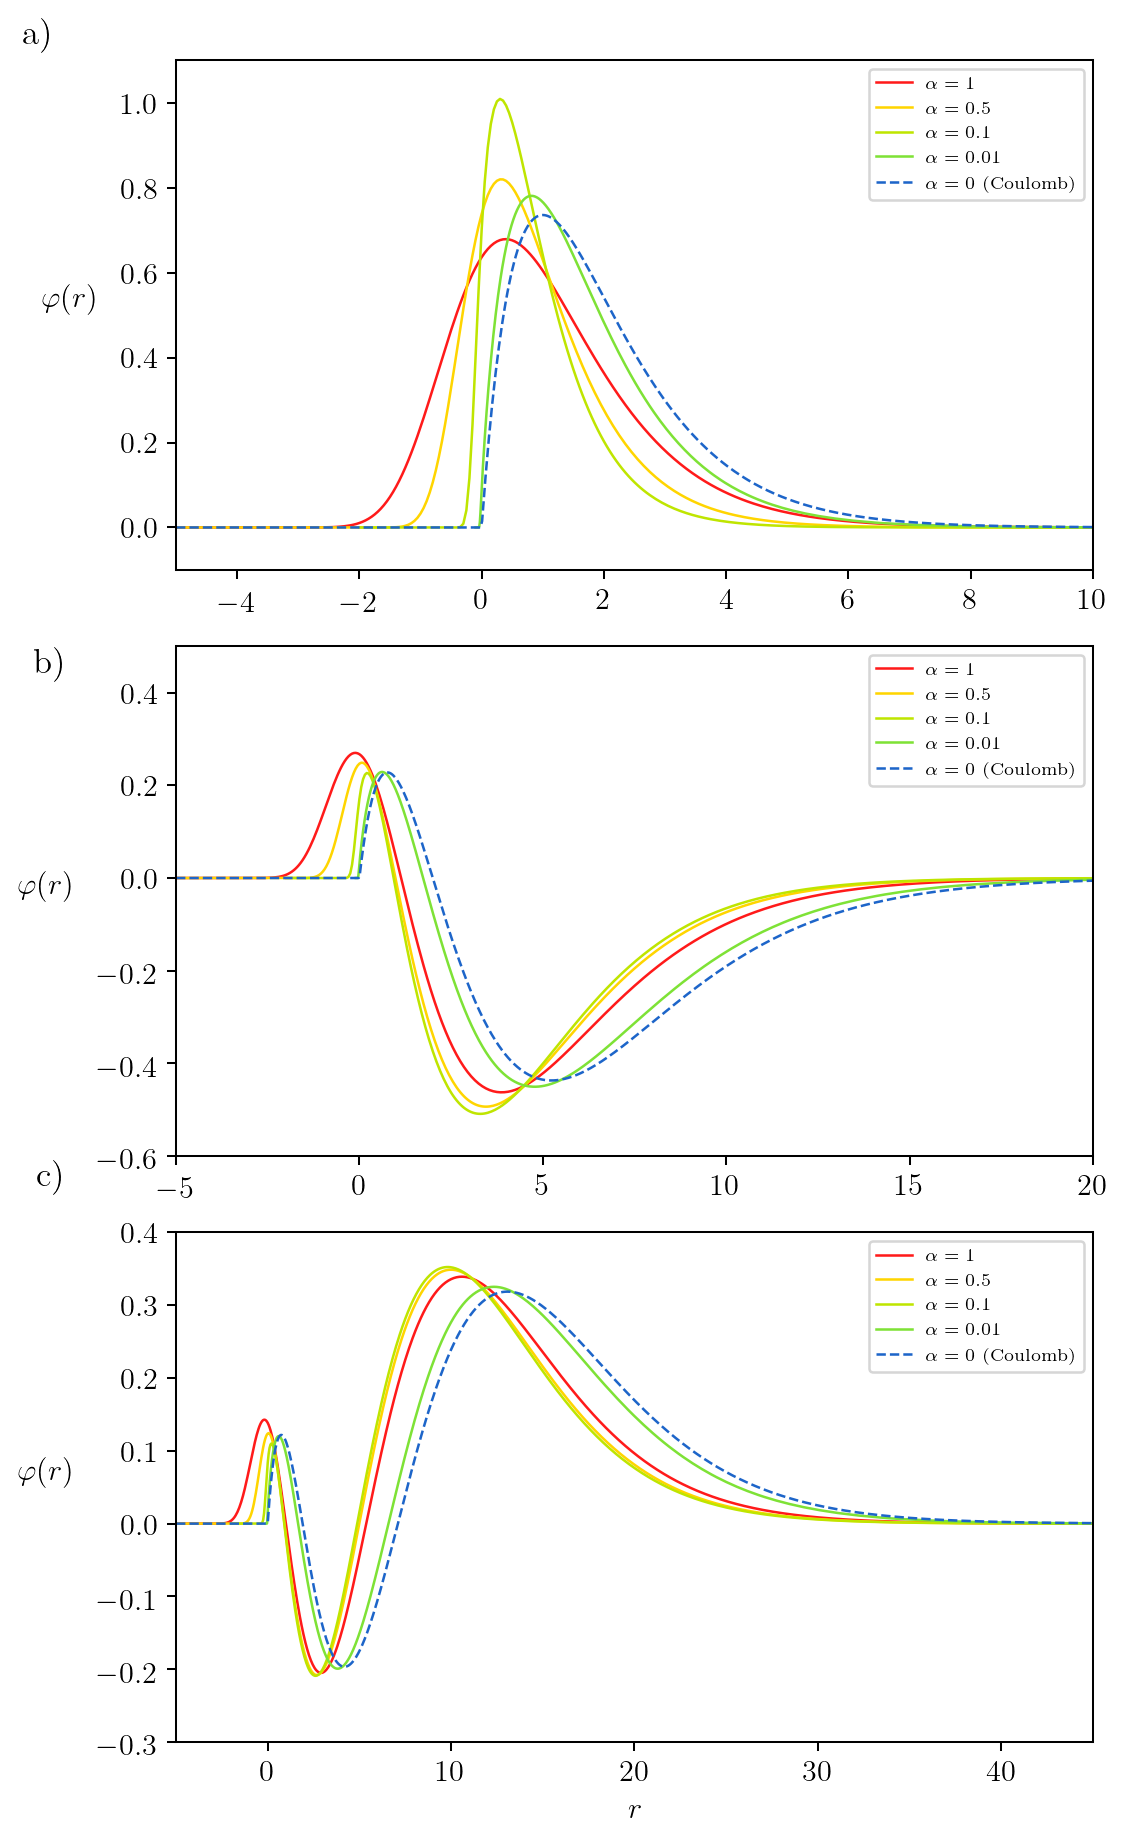

In [7]:
cols = [AmC_BRIGHT_RED, AmC_BOLD_YELLOW, AmC_LIGHT_GREEN, AmC_LIME_GREEN, AmC_DEEP_BLUE]


alpha_001 = json.load(open("Eigenproblem-0.json", "r"))
alpha_01 = json.load(open("Eigenproblem-1.json", "r"))
alpha_05 = json.load(open("Eigenproblem-2.json", "r"))
alpha_1 = json.load(open("Eigenproblem-3.json", "r"))

states_001 = np.array(alpha_001["states"])
states_01 = np.array(alpha_01["states"])
states_05 = np.array(alpha_05["states"])
states_1 = np.array(alpha_1["states"])

rs = np.linspace(-5, 50, 2000)

axs4[0].plot(alpha_1["grid"], -states_1[:, 0], markersize=0, c=cols[0], label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs4[0].plot(alpha_05["grid"], -states_05[:, 0], markersize=0, c=cols[1], label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs4[0].plot(alpha_01["grid"], states_01[:, 0], markersize=0, c=cols[2], label=r"$\alpha = {}$".format(alpha_01["alpha"]) )
axs4[0].plot(alpha_001["grid"], -states_001[:, 0], markersize=0, c=cols[3], label=r"$\alpha = {}$".format(alpha_001["alpha"]) )
axs4[0].plot( rs, [ Coulomb_eigenfunction(r, 1) for r in rs ], markersize=0, c=cols[4], ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs4[0].legend()

axs4[1].plot(alpha_1["grid"], states_1[:, 1], markersize=0, c=cols[0], label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs4[1].plot(alpha_05["grid"], states_05[:, 1], markersize=0, c=cols[1], label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs4[1].plot(alpha_01["grid"], states_01[:, 1], markersize=0, c=cols[2], label=r"$\alpha = {}$".format(alpha_01["alpha"]) )
axs4[1].plot(alpha_001["grid"], -states_001[:, 1], markersize=0, c=cols[3], label=r"$\alpha = {}$".format(alpha_001["alpha"]) )
axs4[1].plot( rs, [ Coulomb_eigenfunction(r, 2) for r in rs ], markersize=0, c=cols[4], ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs4[1].legend()

axs4[2].plot(alpha_1["grid"], -states_1[:, 2], markersize=0, c=cols[0], label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs4[2].plot(alpha_05["grid"], states_05[:, 2], markersize=0, c=cols[1], label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs4[2].plot(alpha_01["grid"], -states_01[:, 2], markersize=0, c=cols[2], label=r"$\alpha = {}$".format(alpha_01["alpha"]) )
axs4[2].plot(alpha_001["grid"], -states_001[:, 2], markersize=0, c=cols[3], label=r"$\alpha = {}$".format(alpha_001["alpha"]) )
axs4[2].plot( rs, [ Coulomb_eigenfunction(r, 3) for r in rs ], markersize=0, c=cols[4], ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs4[2].legend()

fig4


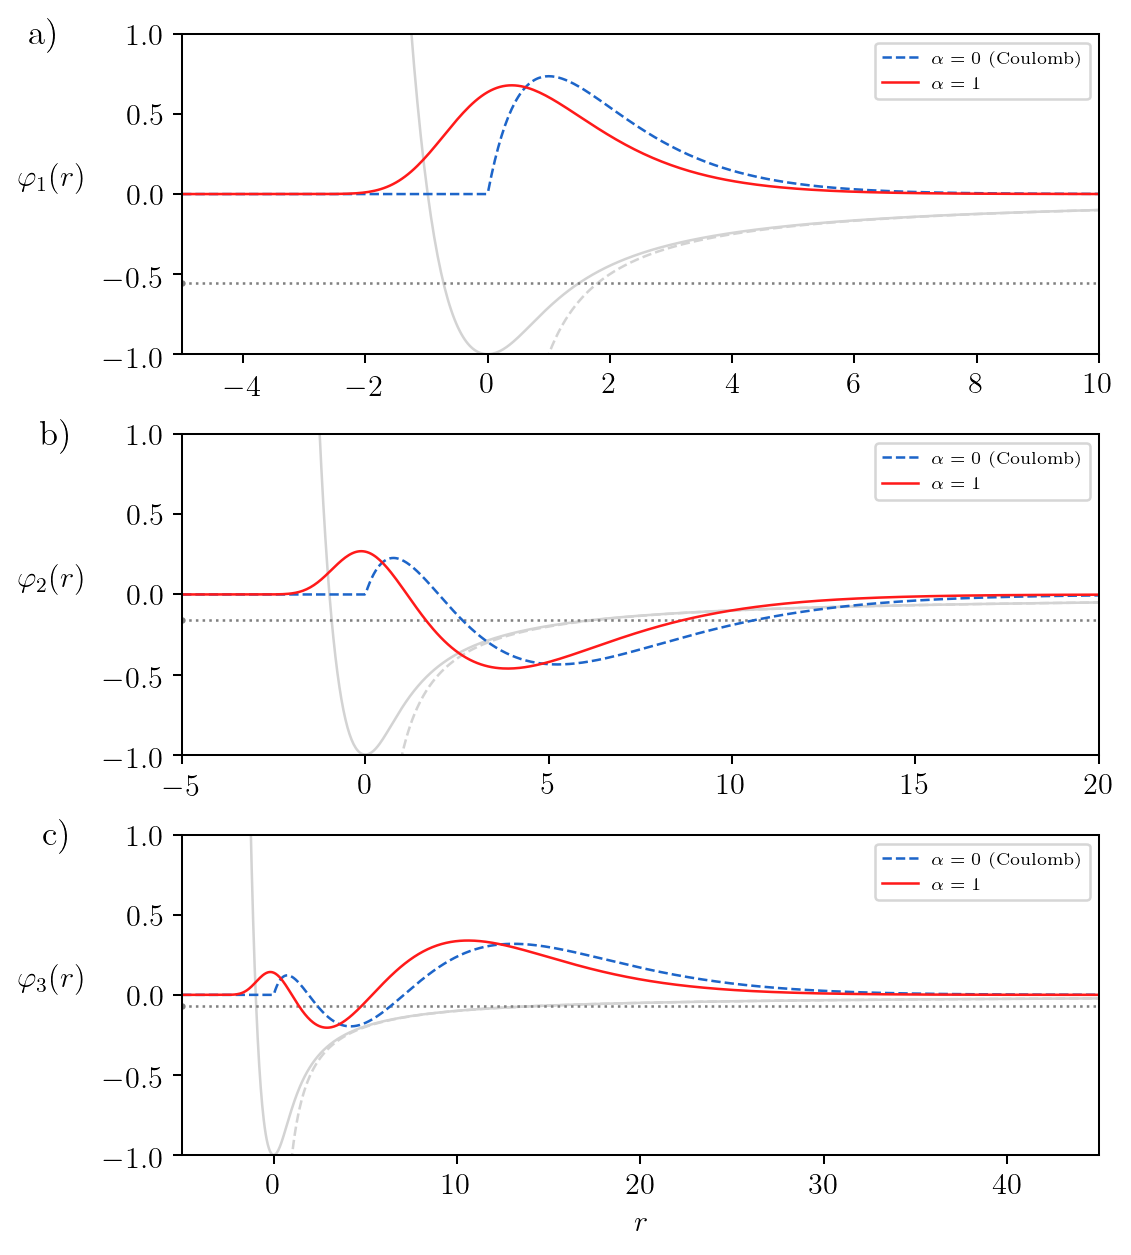

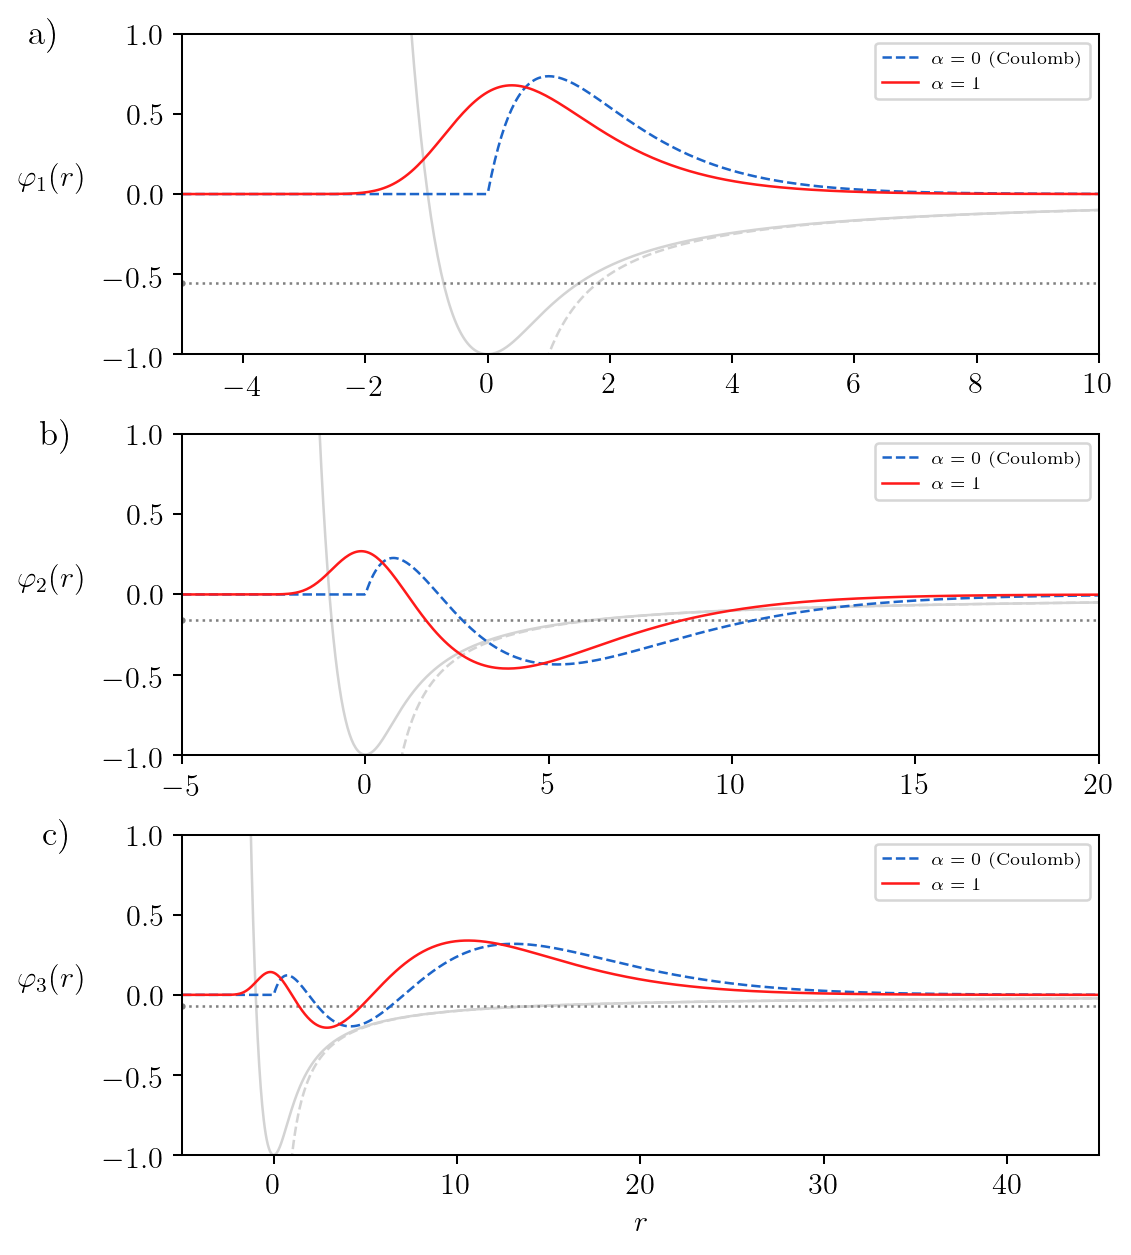

In [8]:
fig1, axs1 = plt.subplots(3, 1)
fig1.set_figwidth(6.5)
fig1.set_figheight(8)
fig1.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.25)

#fig4.gca().set_xlim(-(np.pi*1.01), (np.pi*1.01))
#fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig1.gca().set_xlabel(r"$r$")


axs1[0].set_xlim(-5, 10)
axs1[1].set_xlim(-5, 20)
axs1[2].set_xlim(-5, 45)

axs1[0].set_ylabel(r"$\varphi_1(r)$", rotation=0, labelpad=20)
axs1[1].set_ylabel(r"$\varphi_2(r)$", rotation=0, labelpad=20)
axs1[2].set_ylabel(r"$\varphi_3(r)$", rotation=0, labelpad=20)

axs1[0].text(-7, 1.1, 'a)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs1[1].text(-8, 1.1, 'b)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs1[2].text(-11, 1.1, 'c)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')

alpha_1 = json.load(open("Eigenproblem-3.json", "r"))
states_1 = np.array(alpha_1["states"])

rs = np.linspace(-5, 50, 2000)

n = 0

axs1[n].plot( rs, [ V(alpha_1["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs1[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs1[n].plot( [-5, 50], [alpha_1["energies"][n], alpha_1["energies"][n]], c="grey", ls="dotted" )
axs1[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs1[n].plot(alpha_1["grid"], -states_1[:, n], markersize=0, c=AmC_BRIGHT_RED, label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs1[n].set_ylim(-1, 1)
axs1[n].legend()

n = 1

axs1[n].plot( rs, [ V(alpha_1["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs1[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs1[n].plot( [-5, 50], [alpha_1["energies"][n], alpha_1["energies"][n]], c="grey", ls="dotted" )
axs1[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs1[n].plot(alpha_1["grid"], states_1[:, n], markersize=0, c=AmC_BRIGHT_RED, label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs1[n].set_ylim(-1, 1)
axs1[n].legend()

n = 2

axs1[n].plot( rs, [ V(alpha_1["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs1[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs1[n].plot( [-5, 50], [alpha_1["energies"][n], alpha_1["energies"][n]], c="grey", ls="dotted" )
axs1[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs1[n].plot(alpha_1["grid"], -states_1[:, n], markersize=0, c=AmC_BRIGHT_RED, label=r"$\alpha = {}$".format(alpha_1["alpha"]) )
axs1[n].set_ylim(-1, 1)
axs1[n].legend()


fig1


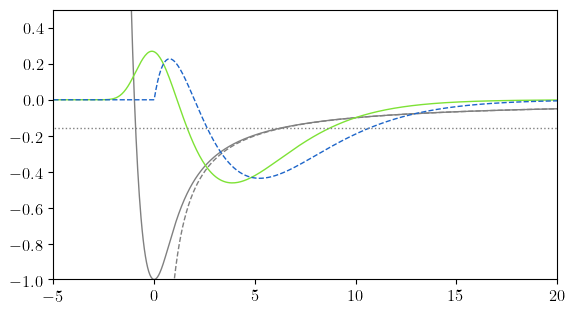

In [9]:
n = 2

plt.plot(rs, [V(1, r) for r in rs], markersize=0, c="grey", alpha=1 )
plt.plot(rs, [Vc(r) for r in rs], markersize=0, c="grey", ls="dashed", alpha=1 )
plt.plot( alpha_1["grid"], states_1[:, n-1], markersize=0, c=AmC_LIME_GREEN )
plt.plot(rs, np.array([ Coulomb_eigenfunction(r, n) for r in rs ]), c=AmC_DEEP_BLUE, ls="dashed", markersize=0)
plt.plot( [-10, 100], [alpha_1["energies"][n-1], alpha_1["energies"][n-1]], markersize=0, c="grey", ls="dotted" )
plt.xlim(-5, 20)
plt.ylim(-1, 0.5)
plt.show()

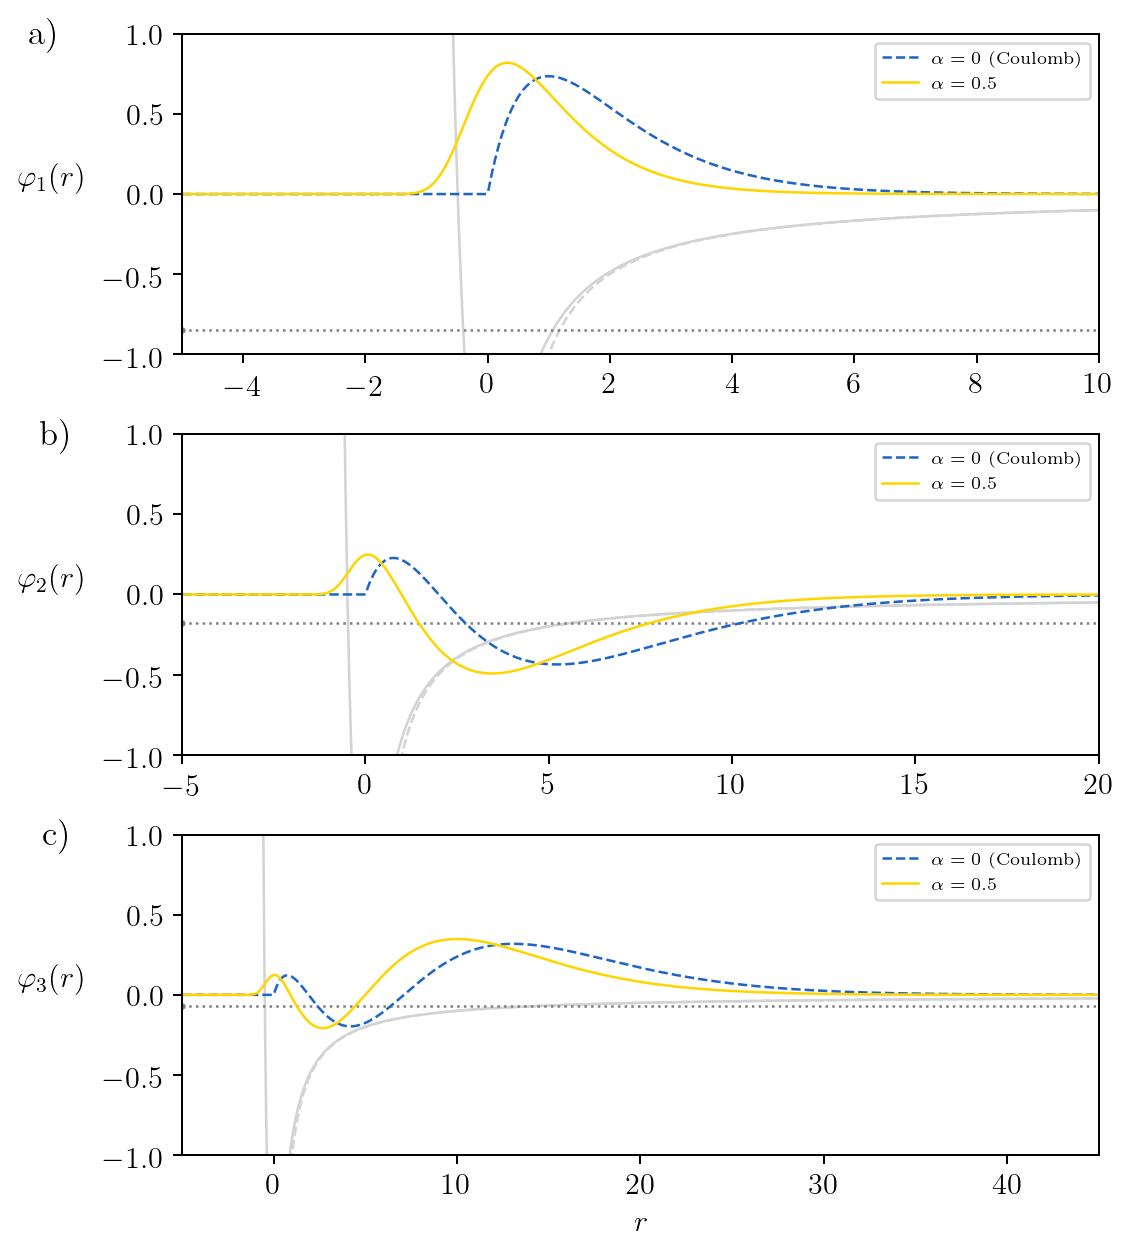

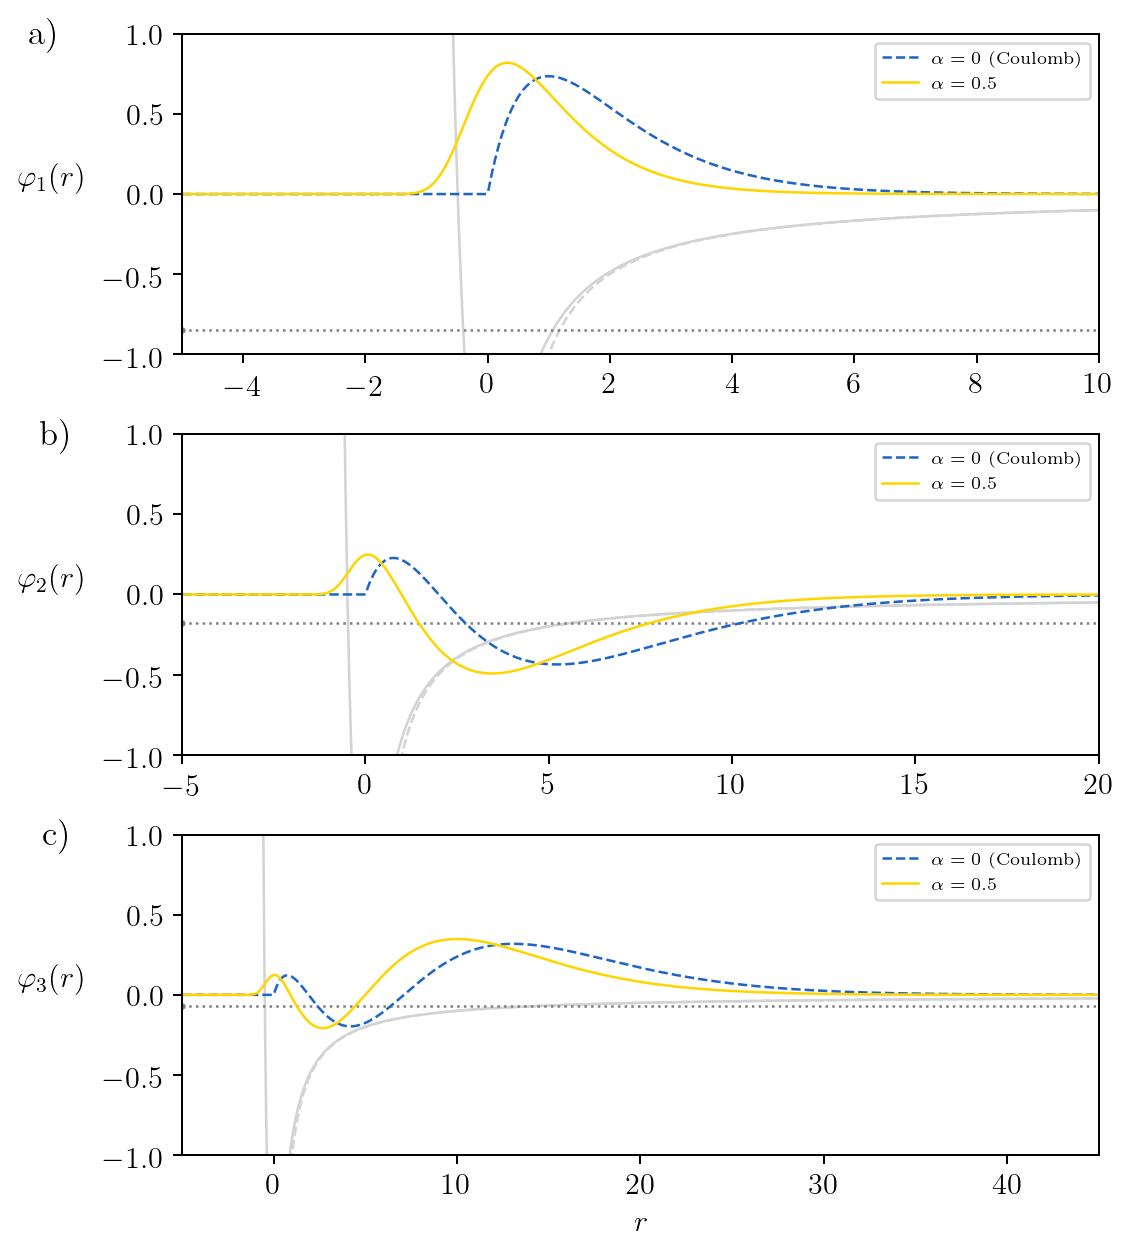

In [10]:
fig2, axs2 = plt.subplots(3, 1)
fig2.set_figwidth(6.5)
fig2.set_figheight(8)
fig2.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.25)

#fig4.gca().set_xlim(-(np.pi*1.01), (np.pi*1.01))
#fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig2.gca().set_xlabel(r"$r$")


axs2[0].set_xlim(-5, 10)
axs2[1].set_xlim(-5, 20)
axs2[2].set_xlim(-5, 45)

axs2[0].set_ylabel(r"$\varphi_1(r)$", rotation=0, labelpad=20)
axs2[1].set_ylabel(r"$\varphi_2(r)$", rotation=0, labelpad=20)
axs2[2].set_ylabel(r"$\varphi_3(r)$", rotation=0, labelpad=20)

axs2[0].text(-7, 1.1, 'a)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs2[1].text(-8, 1.1, 'b)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs2[2].text(-11, 1.1, 'c)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')

alpha_05 = json.load(open("Eigenproblem-2.json", "r"))
states_05 = np.array(alpha_05["states"])


rs = np.linspace(-5, 50, 2000)

n = 0

axs2[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs2[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs2[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs2[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs2[n].plot(alpha_05["grid"], -states_05[:, n], markersize=0, c=AmC_BOLD_YELLOW, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs2[n].set_ylim(-1, 1)
axs2[n].legend()

n = 1

axs2[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs2[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs2[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs2[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs2[n].plot(alpha_05["grid"], states_05[:, n], markersize=0, c=AmC_BOLD_YELLOW, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs2[n].set_ylim(-1, 1)
axs2[n].legend()

n = 2

axs2[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs2[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs2[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs2[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs2[n].plot(alpha_05["grid"], states_05[:, n], markersize=0, c=AmC_BOLD_YELLOW, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs2[n].set_ylim(-1, 1)
axs2[n].legend()


fig2


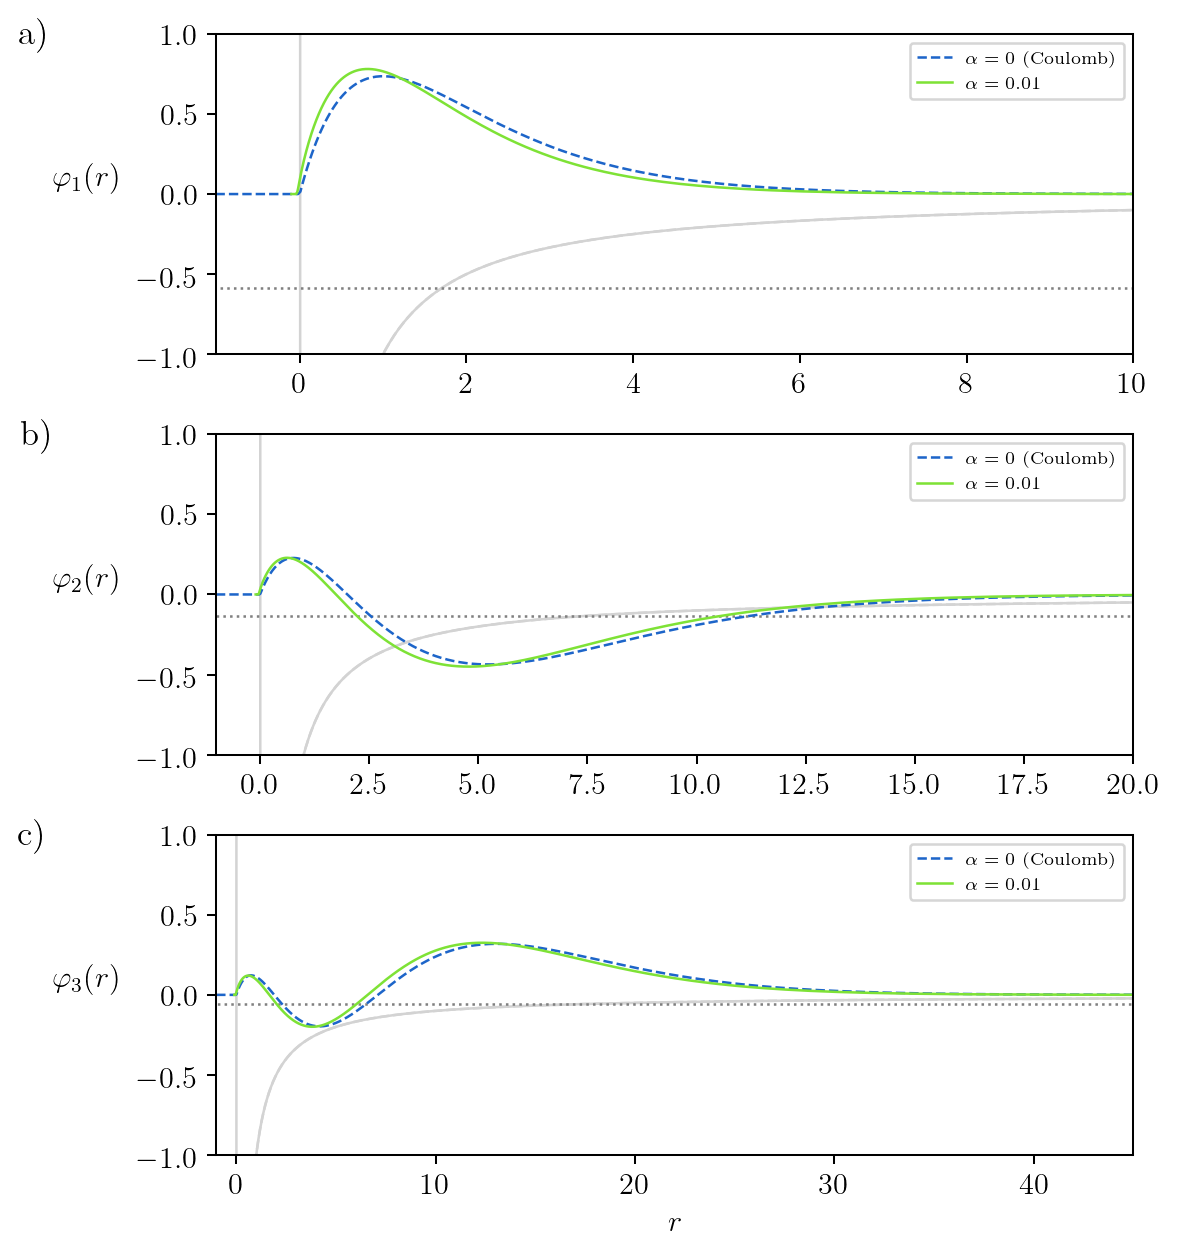

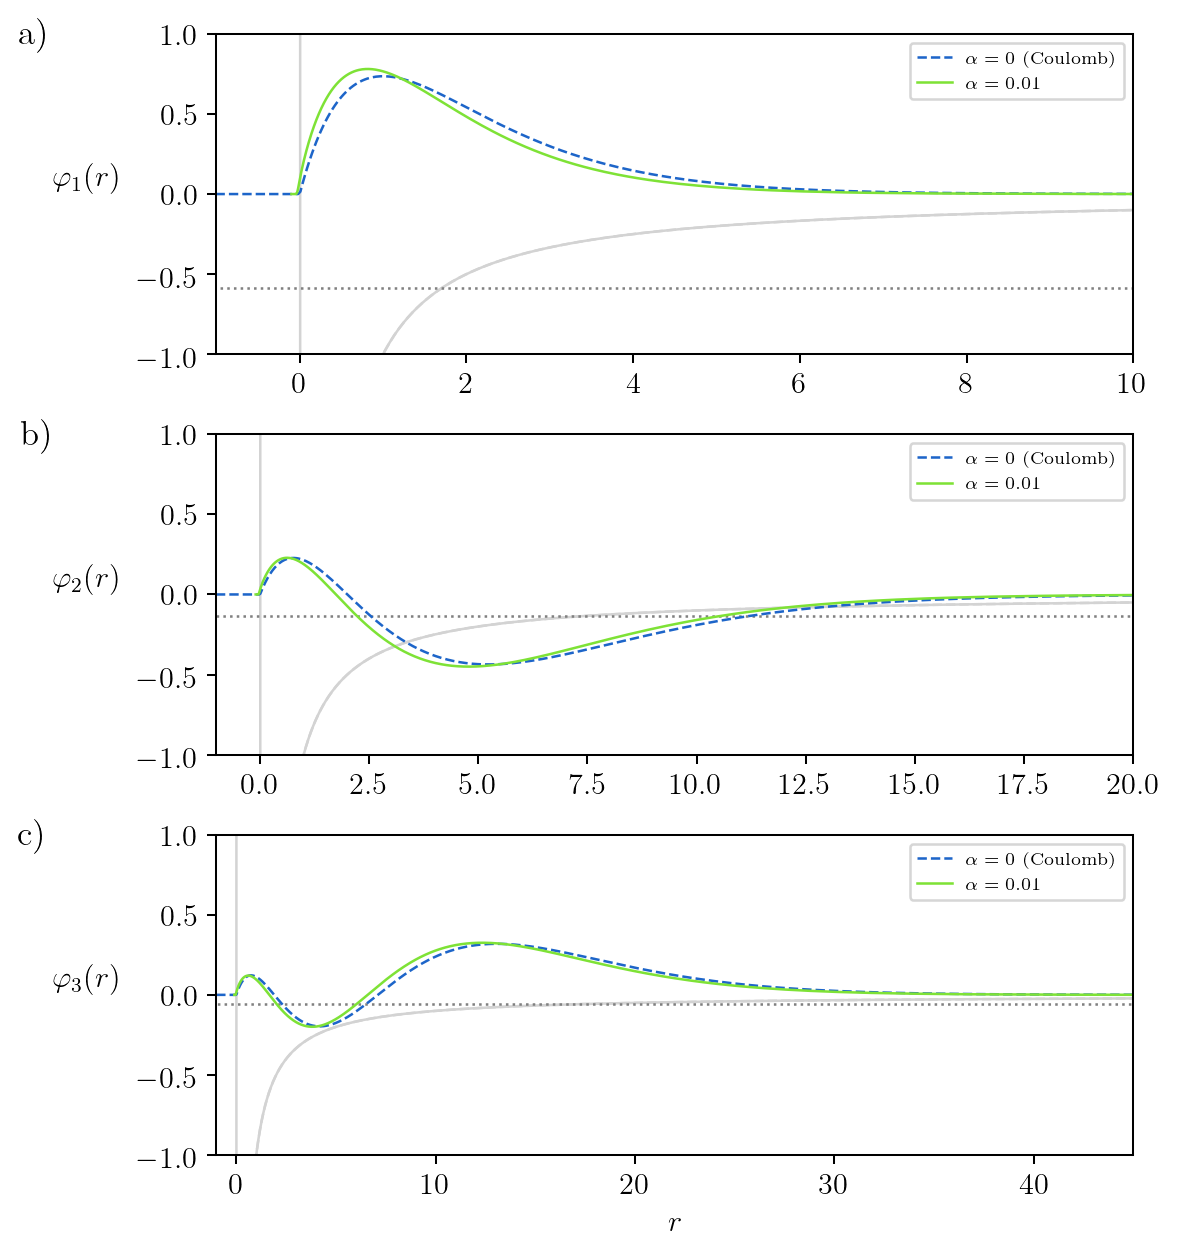

In [11]:
fig3, axs3 = plt.subplots(3, 1)
fig3.set_figwidth(6.5)
fig3.set_figheight(8)
fig3.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.25)

#fig4.gca().set_xlim(-(np.pi*1.01), (np.pi*1.01))
#fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig3.gca().set_xlabel(r"$r$")


axs3[0].set_xlim(-1, 10)
axs3[1].set_xlim(-1, 20)
axs3[2].set_xlim(-1, 45)

axs3[0].set_ylabel(r"$\varphi_1(r)$", rotation=0, labelpad=20)
axs3[1].set_ylabel(r"$\varphi_2(r)$", rotation=0, labelpad=20)
axs3[2].set_ylabel(r"$\varphi_3(r)$", rotation=0, labelpad=20)

axs3[0].text(-3, 1.1, 'a)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs3[1].text(-4.75, 1.1, 'b)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs3[2].text(-9.5, 1.1, 'c)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')

alpha_05 = json.load(open("Eigenproblem-0.json", "r"))
states_05 = np.array(alpha_05["states"])


rs = np.linspace(-5, 50, 2000)

n = 0

axs3[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs3[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs3[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs3[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs3[n].plot(alpha_05["grid"], -states_05[:, n], markersize=0, c=AmC_LIME_GREEN, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs3[n].set_ylim(-1, 1)
axs3[n].legend()

n = 1

axs3[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs3[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs3[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs3[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs3[n].plot(alpha_05["grid"], -states_05[:, n], markersize=0, c=AmC_LIME_GREEN, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs3[n].set_ylim(-1, 1)
axs3[n].legend()

n = 2

axs3[n].plot( rs, [ V(alpha_05["alpha"], r) for r in rs ], markersize=0, c="lightgrey")
axs3[n].plot( rs, [ Vc(r) for r in rs ], markersize=0, c="lightgrey", ls="dashed")
axs3[n].plot( [-5, 50], [alpha_05["energies"][n], alpha_05["energies"][n]], c="grey", ls="dotted" )
axs3[n].plot( rs, [ Coulomb_eigenfunction(r, n+1) for r in rs ], markersize=0, c=AmC_DEEP_BLUE, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")
axs3[n].plot(alpha_05["grid"], -states_05[:, n], markersize=0, c=AmC_LIME_GREEN, label=r"$\alpha = {}$".format(alpha_05["alpha"]) )
axs3[n].set_ylim(-1, 1)
axs3[n].legend()


fig3


In [13]:
def Balmer(n):
    return -1/(2*n**2)

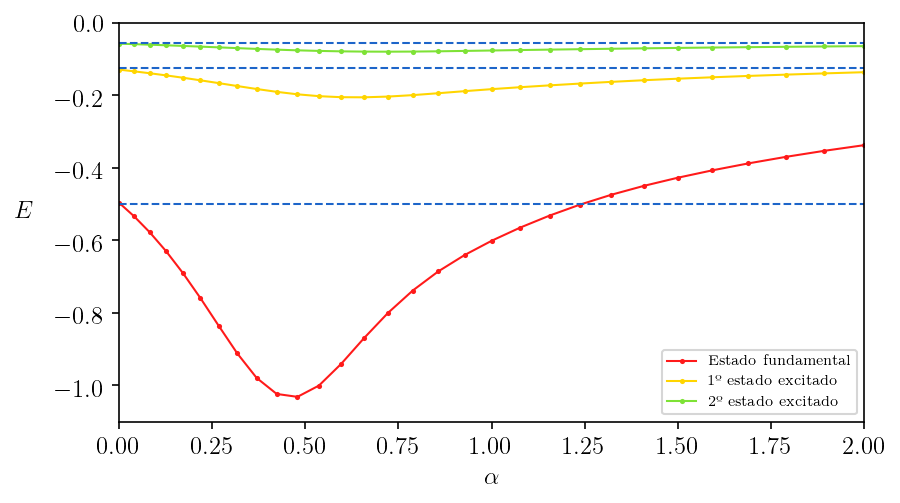

In [14]:
cols = [AmC_BRIGHT_RED, AmC_VIVID_ORANGE, AmC_BOLD_YELLOW, AmC_LIME_GREEN, AmC_DEEP_BLUE]

fig4 = plt.figure(dpi=148)
fig4.gca().set_xlim(0, 2)
fig4.gca().set_ylim(-1.1, 0)

fig4.gca().set_ylabel(r"$E$", rotation=0, labelpad=15)
fig4.gca().set_xlabel(r"$\alpha$")

#fig1.gca().set_title("The Morse-soft-Coulomb potential")


data = json.load(open("EigenEnergies.json", "r"))
E_0s = np.array(data["E_fundamental"])
E_1s = np.array(data["E_first"])
E_2s = np.array(data["E_second"])

alphas = np.array(data["alphas"])

fig4.gca().plot(alphas, E_0s, c=AmC_BRIGHT_RED, label="Estado fundamental")
fig4.gca().plot(alphas, E_1s, c=AmC_BOLD_YELLOW, label="1º estado excitado")
fig4.gca().plot(alphas, E_2s, c=AmC_LIME_GREEN, label="2º estado excitado")

fig4.gca().plot( [0, 2], [Balmer(1), Balmer(1)], markersize=0, c=AmC_DEEP_BLUE, ls="dashed" )
fig4.gca().plot( [0, 2], [Balmer(2), Balmer(2)], markersize=0, c=AmC_DEEP_BLUE, ls="dashed" )
fig4.gca().plot( [0, 2], [Balmer(3), Balmer(3)], markersize=0, c=AmC_DEEP_BLUE, ls="dashed" )


fig4.gca().legend()

In [26]:
def momentum_eigenfunction(phi_r, r_grid):
    delta_r = r_grid[1] - r_grid[0]
    L = r_grid[-1] - r_grid[0]
    N = len(r_grid)
    delta_p = 2*np.pi/L
    n = int((N-1)/2)

    phi_p = np.zeros(2*n+1, dtype=np.complex128)

    for k in range(-n, n+1, 1):
        for i in range(N):
            phi_p[k+n] += (1/np.sqrt(2*np.pi))*np.exp(-k*1j*delta_p*r_grid[i])*phi_r[i]*delta_r

    p_grid = np.linspace(-n*delta_p, n*delta_p, 2*n+1)
    return p_grid, phi_p

def Coulomb_momentum_eigenfunction(p, n):
    return np.sqrt(2*n/np.pi)*(1/( 1 + (n*p)**2 ))*( (1 - n*p*1j)/(1 + n*p*1j) )**(n)

In [27]:
alpha_001 = json.load(open("Eigenproblem-0.json", "r"))
alpha_01 = json.load(open("Eigenproblem-1.json", "r"))
alpha_05 = json.load(open("Eigenproblem-2.json", "r"))
alpha_1 = json.load(open("Eigenproblem-3.json", "r"))

states_001 = np.array(alpha_001["states"])
states_01 = np.array(alpha_01["states"])
states_05 = np.array(alpha_05["states"])
states_1 = np.array(alpha_1["states"])


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

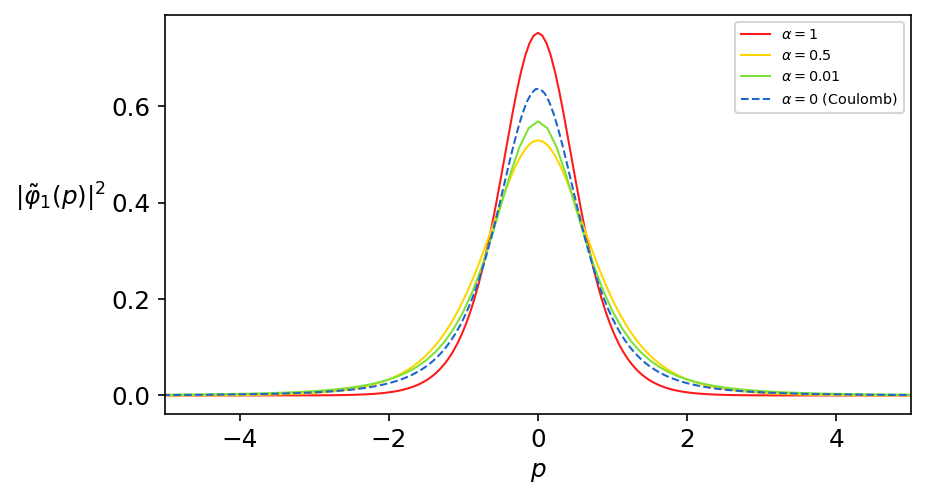

In [28]:
cols = [AmC_BRIGHT_RED, AmC_BOLD_YELLOW, AmC_LIME_GREEN, AmC_DEEP_BLUE]

fig5 = plt.figure(dpi=148)
fig5.gca().set_xlim(-5, 5)
#fig5.gca().set_ylim(-1, 0)

fig5.gca().set_ylabel(r"$|\tilde{\varphi}_1(p)|^2$", rotation=0, labelpad=25)
fig5.gca().set_xlabel(r"$p$")

#fig1.gca().set_title("The Morse-soft-Coulomb potential")

coulomb_p_grid = np.linspace(-30, 30, 1000)
coulomb_phi_p = np.array([ Coulomb_momentum_eigenfunction(p, 1) for p in coulomb_p_grid ])

alphaStates = [alpha_1, alpha_05, alpha_001]

for i in range(3):
    model = alphaStates[i]
    p_grid, phi_p = momentum_eigenfunction( np.array(model["states"])[:, 0], model["grid"])
    fig5.gca().plot(p_grid, np.absolute(phi_p)**2, c=cols[i], markersize=0, label=r"$\alpha = {}$".format(model["alpha"]))
fig5.gca().plot(coulomb_p_grid, np.absolute(coulomb_phi_p)**2, c=AmC_DEEP_BLUE, markersize=0, ls="dashed", label=r"$\alpha = 0$ (Coulomb)")



fig5.gca().legend()

In [29]:
fig1.savefig("Fig3-1.pdf",  bbox_inches="tight")
fig2.savefig("Fig3-2.pdf",  bbox_inches="tight")
fig3.savefig("Fig3-3.pdf",  bbox_inches="tight")
fig5.savefig("Fig3-4.pdf",  bbox_inches="tight")
fig4.savefig("Fig3-5.pdf",  bbox_inches="tight")


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

Text(0.5, 1.0, '$~$')

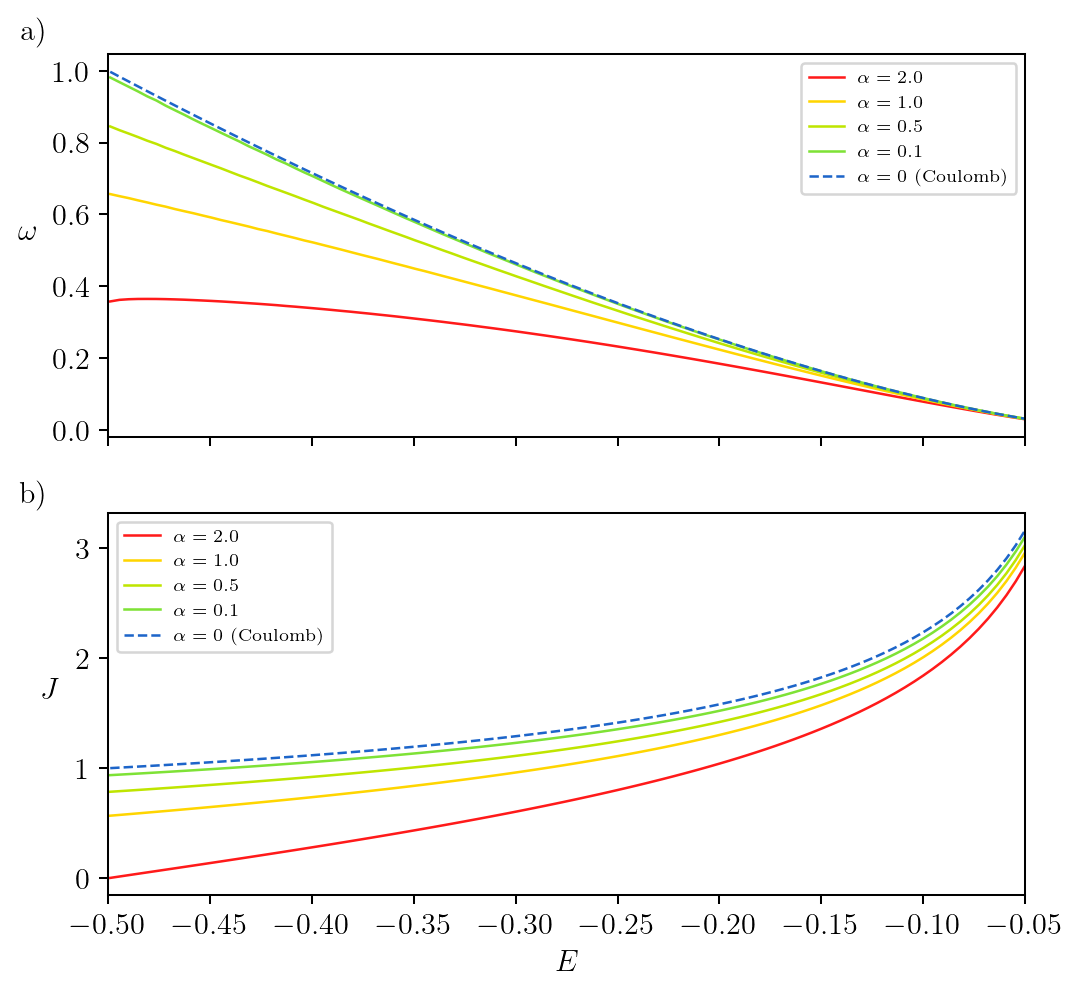

In [6]:
fig2, axs2 = plt.subplots(2, 1, sharex=True)
fig2.set_figwidth(6.5)
fig2.set_figheight(6)
fig2.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.2)

fig2.gca().set_xlim( -0.5, -0.05 )
fig2.gca().set_xlabel(r"$E$")
axs2[0].set_ylabel(r"$\omega$", rotation=0, labelpad=10)
axs2[1].set_ylabel(r"$J$", rotation=0, labelpad=10)
# Show plot
cols = [AmC_BRIGHT_RED, AmC_BOLD_YELLOW, AmC_LIGHT_GREEN, AmC_LIME_GREEN ,AmC_DEEP_BLUE]
Energies = np.linspace(-0.499, -0.05, 100)

for i, alpha in enumerate([2.0, 1.0, 0.5, 0.1, 0]):
    if alpha > 0:
        omgs = np.array([ MC_angular_frequency(alpha, E, 1.e-4) for E in Energies ])
        actions = np.array([ MC_classic_action(alpha, E, 1.e-4) for E in Energies ])

        axs2[0].plot(Energies, omgs, markersize=0, c=cols[i], label=r"$\alpha = {}$".format(alpha))
        axs2[1].plot(Energies, actions, markersize=0, c=cols[i], label=r"$\alpha = {}$".format(alpha))
    else:
        omgs = np.array([ C_angular_frequency(E) for E in Energies ])
        actions = np.array([ C_classic_action(E) for E in Energies ])

        axs2[0].plot(Energies, omgs, markersize=0, ls="dashed", c=cols[i], label=r"$\alpha = 0$ (Coulomb)")
        axs2[1].plot(Energies, actions, markersize=0, ls="dashed", c=cols[i], label=r"$\alpha = 0$ (Coulomb)")

# Add "a)" and "b)" to the top-left corners of the subplots
axs2[0].text(-0.53, max(omgs) + 0.15, 'a)', fontsize=12, verticalalignment='top', horizontalalignment='right')
axs2[1].text(-0.53, max(actions) + 0.45, 'b)', fontsize=12, verticalalignment='top', horizontalalignment='right')

#axs2[0].legend(ncol=4)
#axs2[1].legend(ncol=4)
axs2[0].legend()
axs2[1].legend()
#fig2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4)

#axs2[0].set_title("Oscilating frequency and energy relation for various $\\alpha$")
#axs2[1].set_title("Classical action and energy relation for various $\\alpha$")

axs2[0].set_title("$~$")
axs2[1].set_title("$~$")

    

(0.0, 2.0)

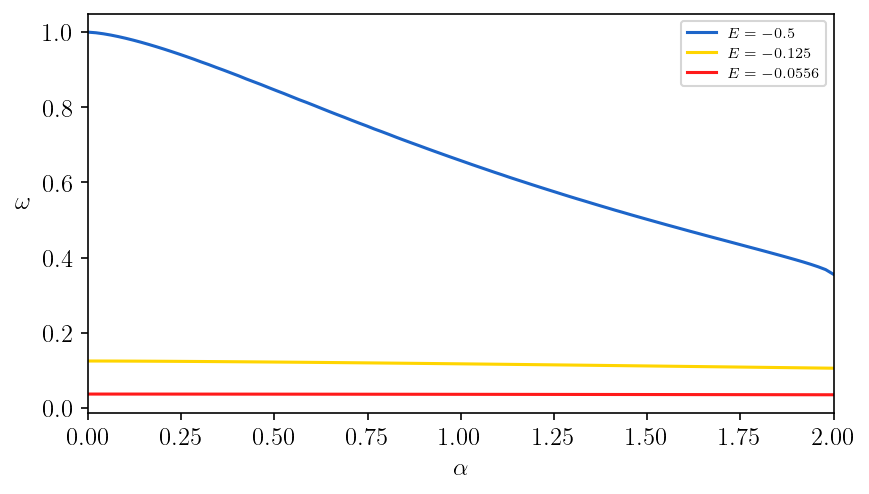

In [7]:
cols = [ AmC_DEEP_BLUE, AmC_BOLD_YELLOW, AmC_BRIGHT_RED ]

fig3 = plt.figure(dpi = 148)
#fig3.gca().set_title("Natural oscilating frequency as a function of $\\alpha$")
alphas = np.linspace(1.e-3, 1.999, 100)

for i, E in enumerate([ -0.5, -0.125, -1/18]):
    omegas = np.array([ MC_angular_frequency(alpha, E, 1.e-5) for alpha in alphas ])
    fig3.gca().plot(alphas, omegas, markersize=0, linewidth=1.5, c=cols[i], label = "$E = {:.3}$".format(E))


fig3.gca().legend()
fig3.gca().set_xlabel("$\\alpha$")
fig3.gca().set_ylabel("$\\omega$", rotation=0, labelpad=10)
fig3.gca().set_xlim(0, 2)
#fig3.gca().set_ylim(0, 0.2)

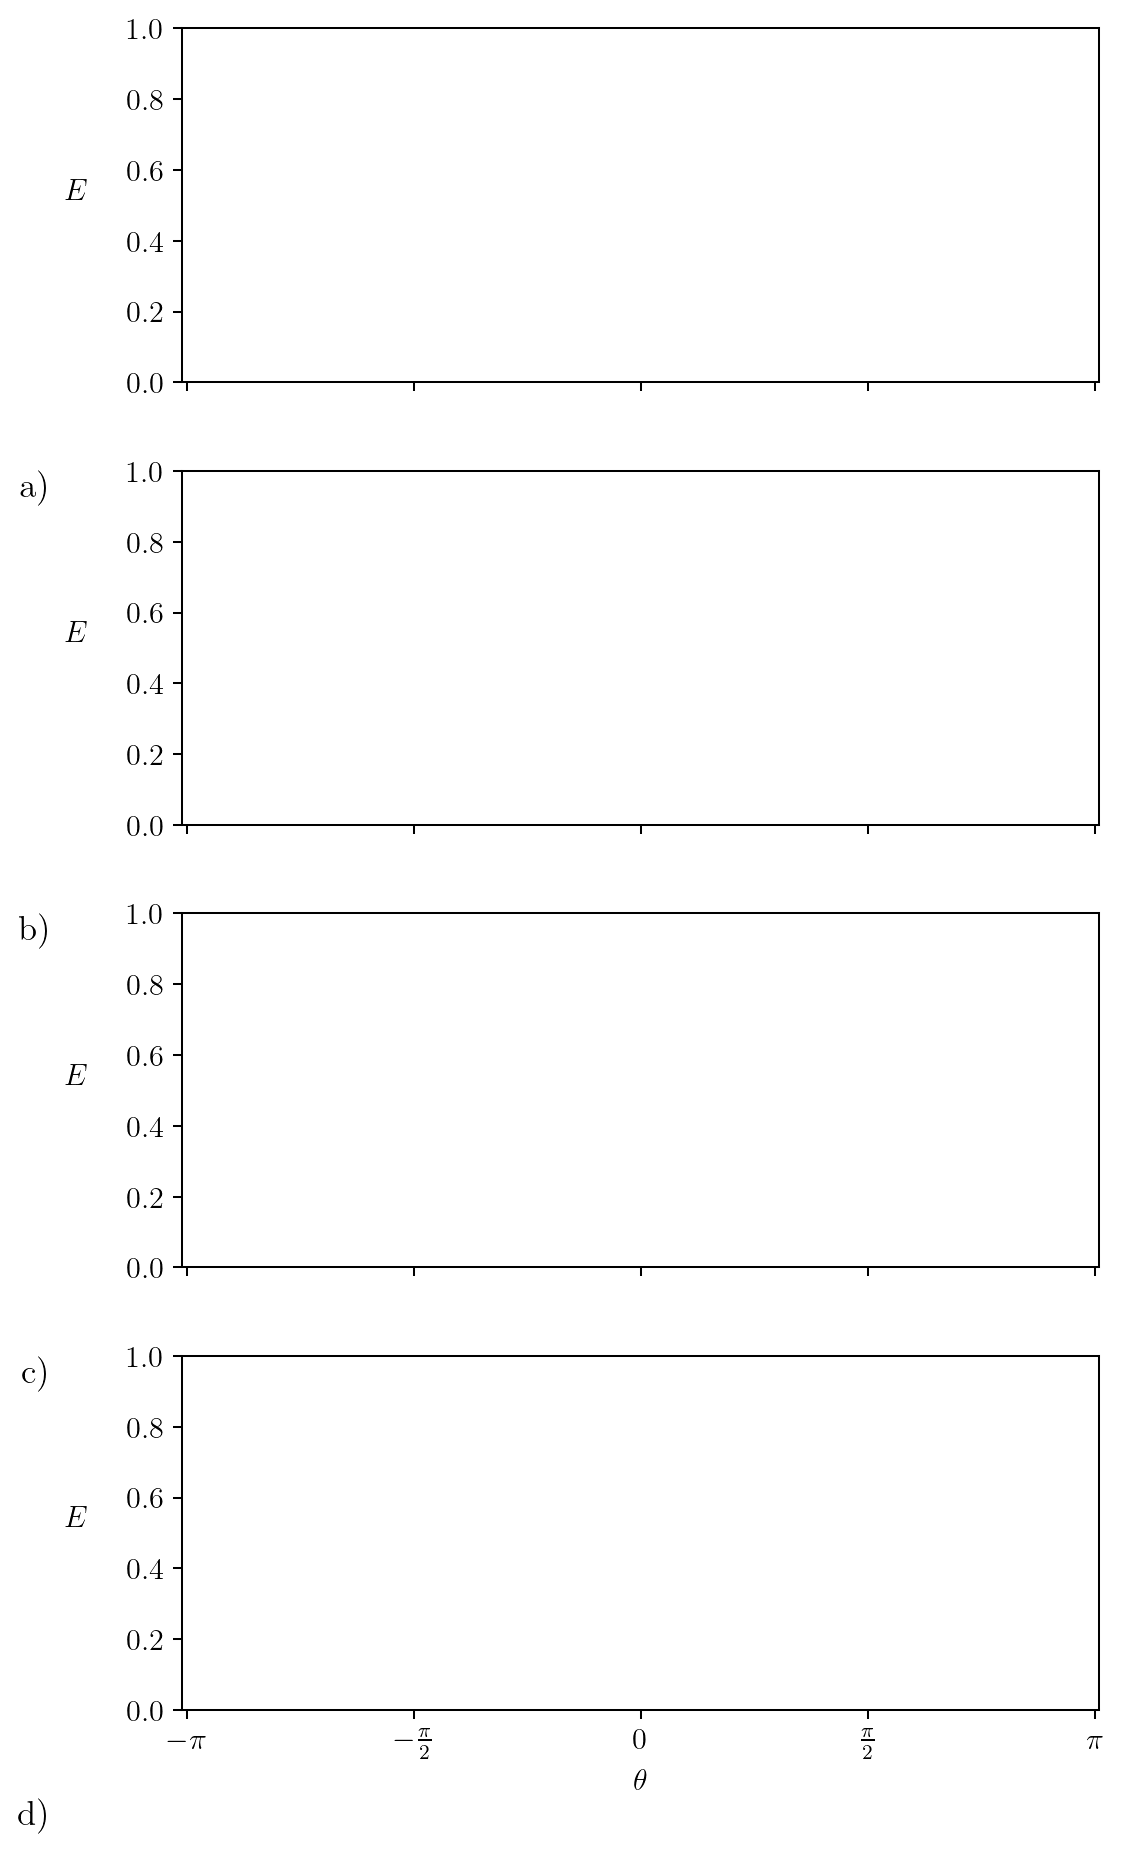

In [8]:
fig4, axs4 = plt.subplots(4, 1, sharex=True)
fig4.set_figwidth(6.5)
fig4.set_figheight(12)
fig4.set_dpi(182)
# Remove vertical spacing between subplots
plt.subplots_adjust(hspace=0.25)

fig4.gca().set_xlim(-(np.pi*1.01), (np.pi*1.01))
fig4.gca().set_xticks(np.arange(-np.pi, np.pi + np.pi/2, np.pi/2), [r"$-\pi$", r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"])
fig4.gca().set_xlabel(r"$\theta$")
axs4[0].set_ylabel(r"$E$", rotation=0, labelpad=20)
axs4[1].set_ylabel(r"$E$", rotation=0, labelpad=20)
axs4[2].set_ylabel(r"$E$", rotation=0, labelpad=20)
axs4[3].set_ylabel(r"$E$", rotation=0, labelpad=20)

axs4[0].text(-np.pi*1.3, -0.25, 'a)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs4[1].text(-np.pi*1.3, -0.25, 'b)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs4[2].text(-np.pi*1.3, -0.25, 'c)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')
axs4[3].text(-np.pi*1.3, -0.25, 'd)', fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='right')

# Show plot
plt.show()

['../Code/Results/PhaseSpace/Tomada2\\04-09-2024--14-41-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada2\\04-09-2024--16-00-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada2\\04-09-2024--17-19-Morse-CoulombAngleEnergies.json', '../Code/Results/PhaseSpace/Tomada2\\10-08-2024--12-33-CoulombAngleEnergies.json']


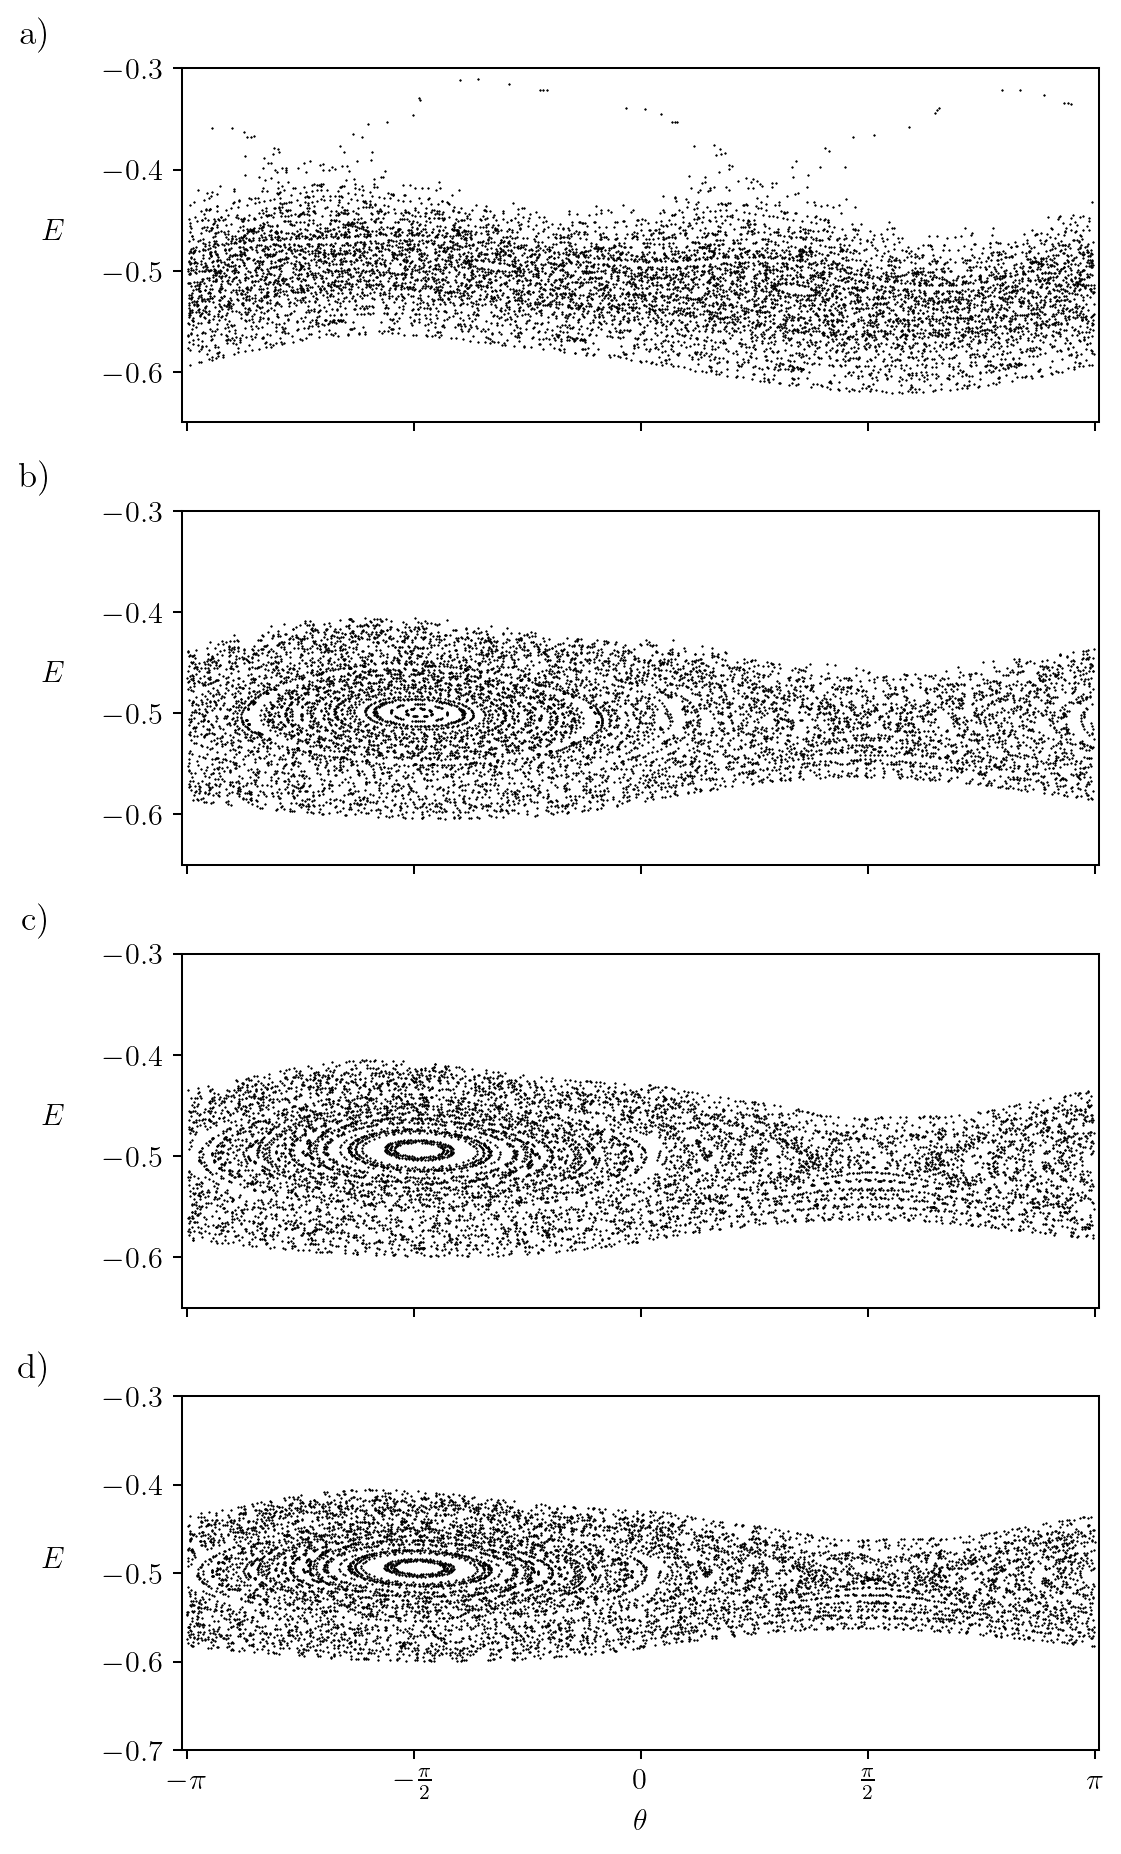

In [18]:
folder_path = results_path + "PhaseSpace/Tomada2"

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)

for i in range(3):
    data = json.load( open(files[i], "r") )

    plotable = data["data"]
    alpha = data["Alpha"]
    section = np.array(data["data"])


    #axs[0].set_ylim(-0.3, -0.24)
    axs4[i].set_ylim(-0.65, -0.3)
    #axs4[i].set_title(r"Poincaré map $\theta \times E$ for $\alpha = {}$".format(alpha))
    axs4[i].scatter( section[:, 0], section[:, 1], s=2.5, marker=".", lw=0, c="black" )

data = json.load( open(files[3], "r") )

plotable = data["data"]
section = np.array(data["data"])


axs4[3].set_ylim(-0.7, -0.3)
#axs4[3].set_title(r"Poincaré map $\theta \times E$ for $\alpha = 0$ (Coulomb)")
axs4[3].scatter( section[:, 0], section[:, 1], s=2.5, marker=".", lw=0, c="black" )
fig4

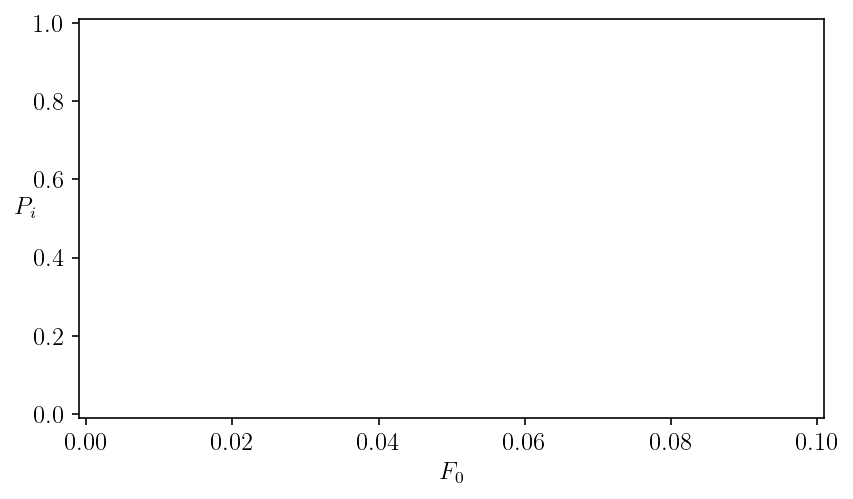

In [10]:
F0s = np.arange(0, 0.105, 0.005)

fig5 = plt.figure(dpi=148)
#fig5.gca().set_title("Ionization probability and amplitude relation for various $\\alpha$")
fig5.gca().set_xlabel( r"$F_0$" )
fig5.gca().set_ylabel( r"$P_i$", rotation=0 )
fig5.gca().set_xlim( -0.001, 0.101 )
fig5.gca().set_ylim( -0.01, 1.01 )
fig5.gca().set_xticks( np.arange(0.0, 0.12, 0.02) )

In [11]:
folder_path = results_path + 'ProbabilityXAmplitude/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)


['../Code/Results/ProbabilityXAmplitude/Tomada1\\25-06-2024--16-56-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1\\25-06-2024--18-22-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1\\25-06-2024--19-55-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1\\27-06-2024--03-01-Morse-Coulomb-ionizationNumba-Amplitude.json', '../Code/Results/ProbabilityXAmplitude/Tomada1\\27-06-2024--06-09-Coulomb-ionizationNumba-Amplitude.json']


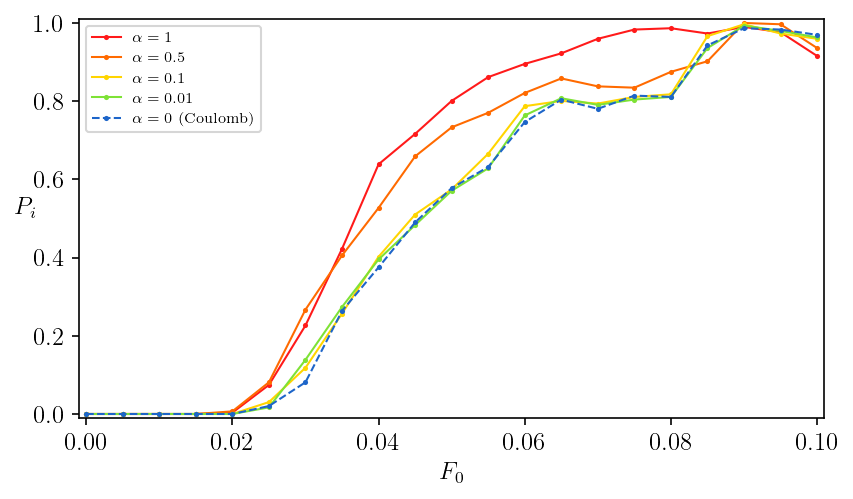

In [12]:
cols = [AmC_BRIGHT_RED, AmC_VIVID_ORANGE, AmC_BOLD_YELLOW, AmC_LIME_GREEN, AmC_DEEP_BLUE]
for i, f in enumerate(files):

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    if alpha > 0:
        fig5.gca().plot( F0s, Pis, label=r"$\alpha = {}$".format(alpha), color=cols[i], markersize=5 )
    else:
        fig5.gca().plot( F0s, Pis, label=r"$\alpha = 0$ (Coulomb)", color=cols[i], markersize=5, ls="dashed" )
         
    fig5.gca().legend(loc=2)
    i += 1

fig5

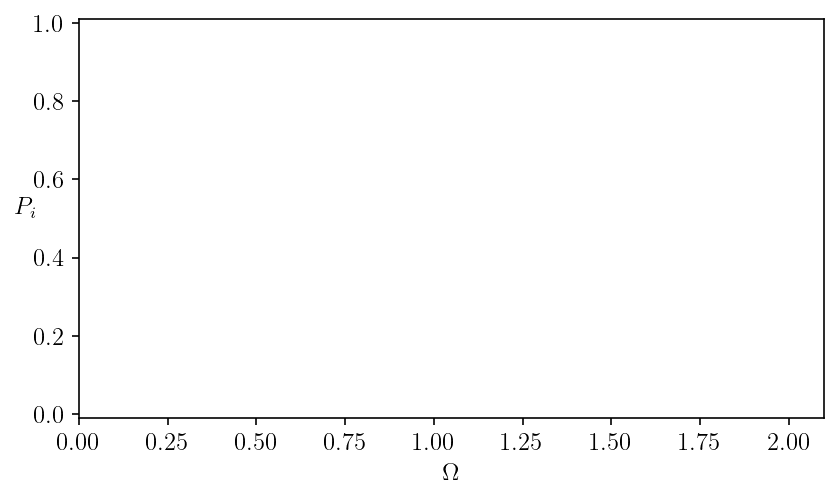

In [13]:
Omgs = np.arange(0.05, 2.1, 0.05)

fig6 = plt.figure(dpi=148)
#fig6.gca().set_title("Ionization probability and frequency relation for various $\\alpha$")
fig6.gca().set_xlabel( r"$\Omega$" )
fig6.gca().set_ylabel( r"$P_i$", rotation=0 )
fig6.gca().set_xlim( 0, 2.1 )
fig6.gca().set_ylim( -0.01, 1.01 )
fig6.gca().set_xticks( np.arange(0.0, 2.1, 0.25) )

In [14]:
folder_path = results_path + 'ProbabilityXFrequency/Tomada1'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)


['../Code/Results/ProbabilityXFrequency/Tomada1\\01-08-2024--10-34-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1\\26-07-2024--15-01-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1\\26-07-2024--17-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1\\26-07-2024--18-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1\\26-07-2024--19-11-Morse-Coulomb-ionizationNumba-Frequency.json', '../Code/Results/ProbabilityXFrequency/Tomada1\\29-07-2024--21-51-Morse-Coulomb-ionizationNumba-Frequency.json']


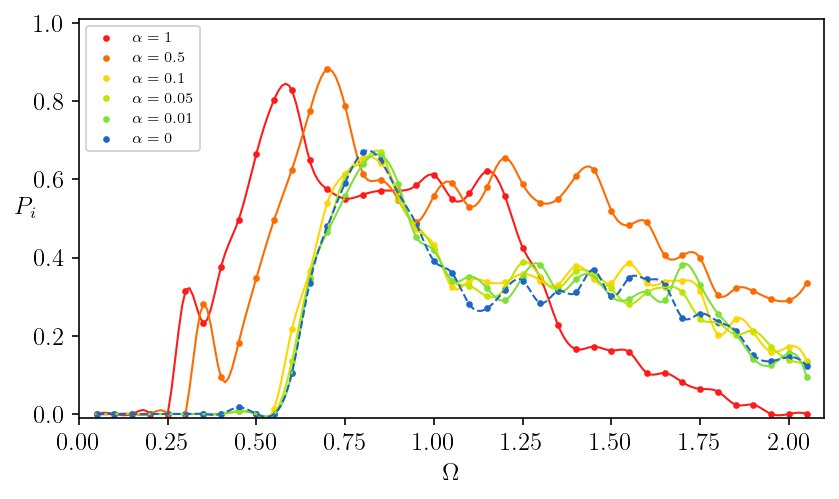

In [15]:
from scipy.interpolate import CubicSpline

i = 1
cols = ['#1d65c9', '#ff1a1a', '#ff6a00', '#ffd500', '#bfe500', '#7ee236']
for f in files[1:]:

    with open( f, "r" ) as filehandle:
        data = json.load(filehandle)

    plotable = data["data"]
    alpha = data["Alpha"]

    Pis = list(plotable.values())

    spln = CubicSpline(Omgs, Pis)

    x_new = np.linspace(Omgs[0], Omgs[-1], 200)
    y_new = spln(x_new)

    #alphas.append(alpha)
    #Pis.append(plotable["0.06"])

    fig6.gca().scatter( Omgs, Pis, label=r"$\alpha = {}$".format(alpha), color=cols[i], s=5 )
    fig6.gca().plot( x_new, y_new, color=cols[i], markersize=0 )
    fig6.gca().legend(loc=2)
    i += 1

with open( files[0], "r" ) as filehandle:
        data = json.load(filehandle)

plotable = data["data"]
alpha = data["Alpha"]

Pis = list(plotable.values())
spln = CubicSpline(Omgs, Pis)

x_new = np.linspace(Omgs[0], Omgs[-1], 500)
y_new = spln(x_new)

#alphas.append(alpha)
#Pis.append(plotable["0.06"])
fig6.gca().scatter( Omgs, Pis, label="$\\alpha = 0$", color=cols[0], s=5 )
fig6.gca().plot( x_new, y_new, color=cols[0], markersize=0, ls="dashed" )
fig6.gca().legend(loc=2)

fig6

['../Code/Results/ProbabilityXAlpha/Tomada2\\16-08-2024--23-51-Morse-Coulomb-ionizationNumba-Alphas.json']


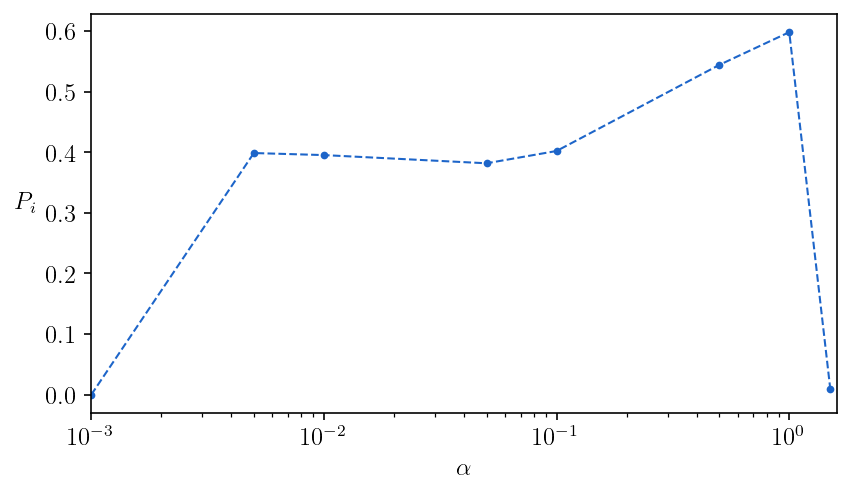

In [16]:
fig7 = plt.figure(dpi=148)
#fig7.gca().set_title("Ionization probability for various $\\alpha$")
fig7.gca().set_xlabel( r"$\alpha$" )
fig7.gca().set_ylabel( r"$P_i$", rotation=0, labelpad=10 )
fig7.gca().set_xlim( 1.e-3, 1.6 )
#fig7.gca().set_ylim( -0.01, 0.06 )
#fig4.gca().set_xticks( np.arange(0.0, 1.58, 0.3) )

folder_path = results_path + 'ProbabilityXAlpha/Tomada2'

# Get list of all files and directories
all_items = os.listdir(folder_path)

# Filter out only files
files = [os.path.join(folder_path, f) for f in all_items if os.path.isfile(os.path.join(folder_path, f))]

print(files)
data = json.load( open(files[0], "r") )
plotable = data["data"]

Pis = list(plotable.values())
Alphas = data["Alphas"]

fig7.gca().plot( Alphas[1:], Pis[1:], color=AmC_DEEP_BLUE, ls="dashed", markersize=7.5 )
fig7.gca().set_xscale('log')

In [17]:
figdir = "Figures/"

figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7]

for i, fig, in enumerate(figs):
    fig.savefig(figdir + "Figure_" + str(i+1) + ".pdf", bbox_inches="tight")